In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FixedLocator, FixedFormatter, LogLocator, NullFormatter, LogFormatter, EngFormatter, AutoMinorLocator)
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm
import struct
%matplotlib inline

# Defaults more suitable for 4K monitors
mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["figure.figsize"] = [6.0, 4.0]

# Export settings
mpl.rcParams["savefig.bbox"] = 'tight'
mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["savefig.facecolor"] = 'white'

# Lossless using WebP
#mpl.rcParams["animation.codec"] = 'webp'
#mpl.rcParams["animation.ffmpeg_args"] = ["-preset", "drawing", "-lossless", "1"]
# Use anim.save("movie.webp", fps=60)

# Lossy using AV1
mpl.rcParams["animation.codec"] = 'libaom-av1'
mpl.rcParams["animation.ffmpeg_args"] = []
# Use anim.save("movie.webm", fps=60)


In [60]:
import glob
import re

dfs = []
for path in glob.glob('./results/*/*/*.csv'):
    if 'skip' in path:
        continue
    m = re.match(r'.*/(.*)/(.*)/([^/]*)\.csv', path)
    (machine, algo, run) = (m.group(1), m.group(2), m.group(3))
    df = pd.read_csv(path)
    df['machine'] = machine
    df['algo'] = algo
    df['run'] = run
    dfs.append(df)
df = pd.concat(dfs)

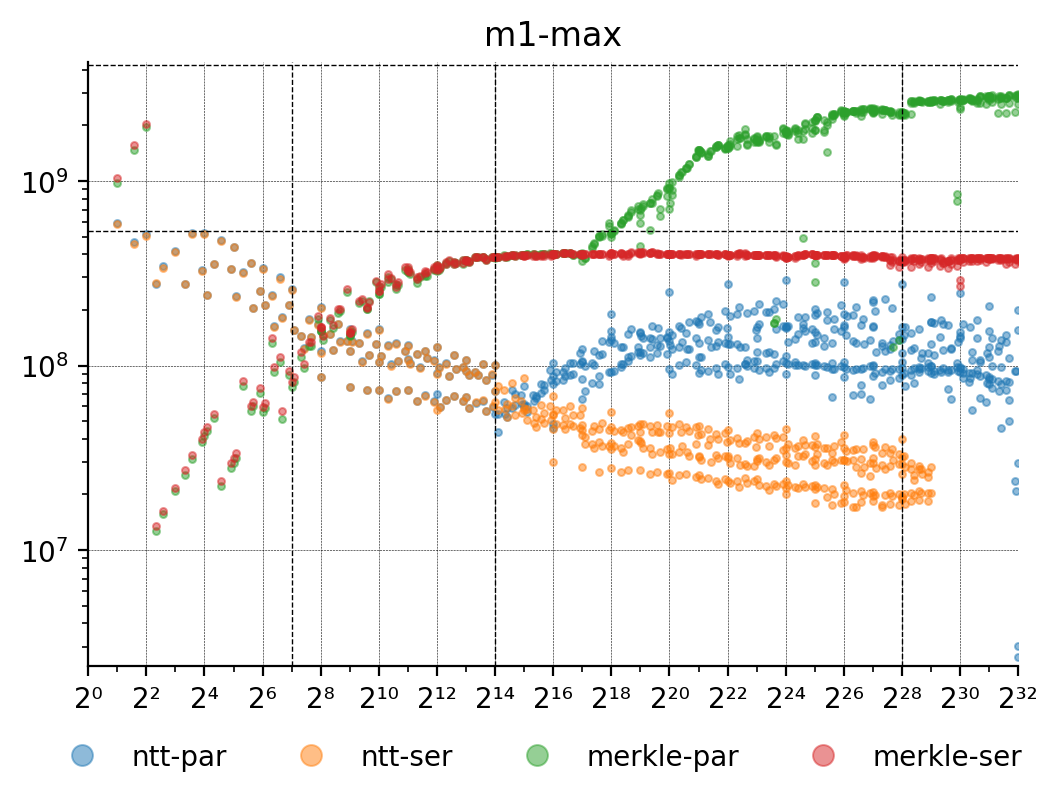

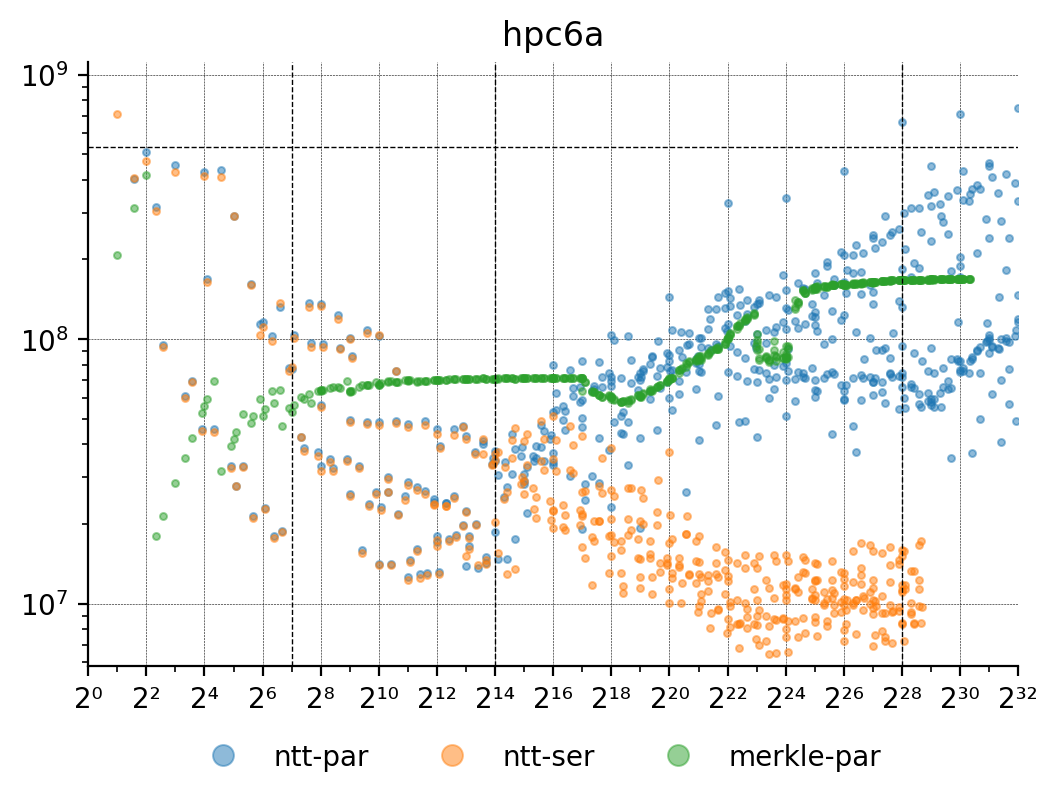

In [61]:
for machine in df['machine'].unique():

    fig, ax = plt.subplots()

    # Plot algos and runs for the machine
    dfm = df[df['machine'] == machine]
    min_y = 1e20
    max_y = 0.0
    for algo in dfm['algo'].unique():
        dfa = dfm[dfm['algo'] == algo]
        runs = dfa['run'].unique()
        runs.sort()
        for run in runs:
            dfr = dfa[dfa['run'] == run]
            min_y = min(min_y, dfa['throughput'].min())
            max_y = max(max_y, dfa['throughput'].max())
            ax.plot(dfr['size'], dfr['throughput'], marker='.', alpha=0.5, markersize=5, markeredgewidth=0.7, linestyle='none', linewidth=0.5, label=algo+run)
    
    # Framing
    ax.set_title(machine)
    ax.set_clip_on(False)
    for s in ['top', 'right']:
        ax.spines[s].set_visible(False)
    
    # X axis
    ax.set_xlim((2**0, 2**32))
    ax.set_xscale('log')
    ax.xaxis.set_major_locator(FixedLocator([2**i for i in range(0,35,2)]))
    ax.xaxis.set_major_formatter(FixedFormatter(["2⁰", "2²", "2⁴", "2⁶", "2⁸", "2¹⁰", "2¹²", "2¹⁴", "2¹⁶", "2¹⁸", "2²⁰", "2²²", "2²⁴", "2²⁶", "2²⁸", "2³⁰", "2³²", "2³⁴"]))
    ax.xaxis.set_minor_locator(FixedLocator([2**i for i in range(0,33)]))
    ax.xaxis.set_minor_formatter(NullFormatter())
    
    ax.xaxis.grid(True, which='major', color='black', linewidth=0.2, linestyle='--')
    ax.axvline(128, linewidth=0.5, linestyle='--', color='black') # Small codelets
    ax.axvline(2**14, linewidth=0.5, linestyle='--', color='black') # 2nd level
    ax.axvline(2**28, linewidth=0.5, linestyle='--', color='black') # 3rd level

    ax.axhline(3.2e9 / 0.75 / 8, linewidth=0.5, linestyle='--', color='black') # K12 single core throughput
    ax.axhline(8 * 3.2e9 / 0.75 / 8, linewidth=0.5, linestyle='--', color='black') # K12 mulit core throughput

    # Y axis
    ax.set_ylim((0.9 * min_y, 1.5 * max_y))
    #ax.set_ylim((1e6, 1e9))
    # if machine == 'm1-max':
    #     ax.set_ylim((0.9 * min_y, 20e7))
    # if machine == 'hpc6a':
    #     ax.set_ylim((4e5, 4e7))
    # if machine == 'a15':
    #     ax.set_ylim((0.7e5, 1e7))
    ax.set_yscale('log')
    ax.yaxis.grid(True, which='major', color='black', linewidth=0.2, linestyle='--')
    
    fig.legend(bbox_to_anchor=(0.5, 0.06), loc='upper center', ncol=4, frameon=False, markerscale=3)
    
    fig.savefig(f'bench-{machine}.png')


# 

In [47]:
8 * 3.2e9 / 0.75 / 1e9

34.13333333333333

In [113]:
def jsonf(path):
    import json
    with open(path, 'r') as f:
        return json.load(f)

In [118]:
df = []
for path in glob.glob('../target/criterion/**/new/benchmark.json', recursive=True):
    m = re.match(r'(.*/criterion/(.*)/(.*))/new/.*', path)
    (base, name) = (m.group(1), m.group(2))
    meta = jsonf(f'{base}/new/benchmark.json')
    new = jsonf(f'{base}/new/estimates.json')
    old = jsonf(f'{base}/main/estimates.json')
    elms = meta['throughput']['Elements']
    new_mean = new['mean']['point_estimate'] * 1e-9
    old_mean = old['mean']['point_estimate'] * 1e-9
    new_ops = elms / new_mean
    old_ops = elms / old_mean
    name = name.replace('field/', '')
    df += [dict(name=name, elms=elms, new_ops=new_ops, old_ops=old_ops)]
df = pd.DataFrame.from_dict(df)

In [119]:
sorter = ['add', 'sub', 'mul']
sorterIndex = dict(zip(sorter, range(len(sorter))))
df['rank'] = df['name'].map(sorterIndex)
df.sort_values(['rank', 'name'], ascending = [True, True], inplace = True)

In [120]:
df = df[df['name'] != 'inv']
df = df[df['name'] != 'inv_addchain']

In [122]:
df

,name,elms,new_ops,old_ops,rank
84,add,32,6.391544e+09,6.313993e+09,0.0
85,add,16,6.061383e+09,6.036986e+09,0.0
86,add,1,1.064097e+09,1.068771e+09,0.0
87,add,8,3.984368e+09,3.980090e+09,0.0
88,add,4,2.135795e+09,2.096564e+09,0.0
...,...,...,...,...,...
91,shift_64,16,3.120676e+09,3.178860e+09,NaN
92,shift_64,1,5.351212e+08,5.348373e+08,NaN
93,shift_64,8,2.214945e+09,2.249978e+09,NaN
94,shift_64,4,1.197886e+09,1.212809e+09,NaN


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (15,) and arg 1 with shape (8,).

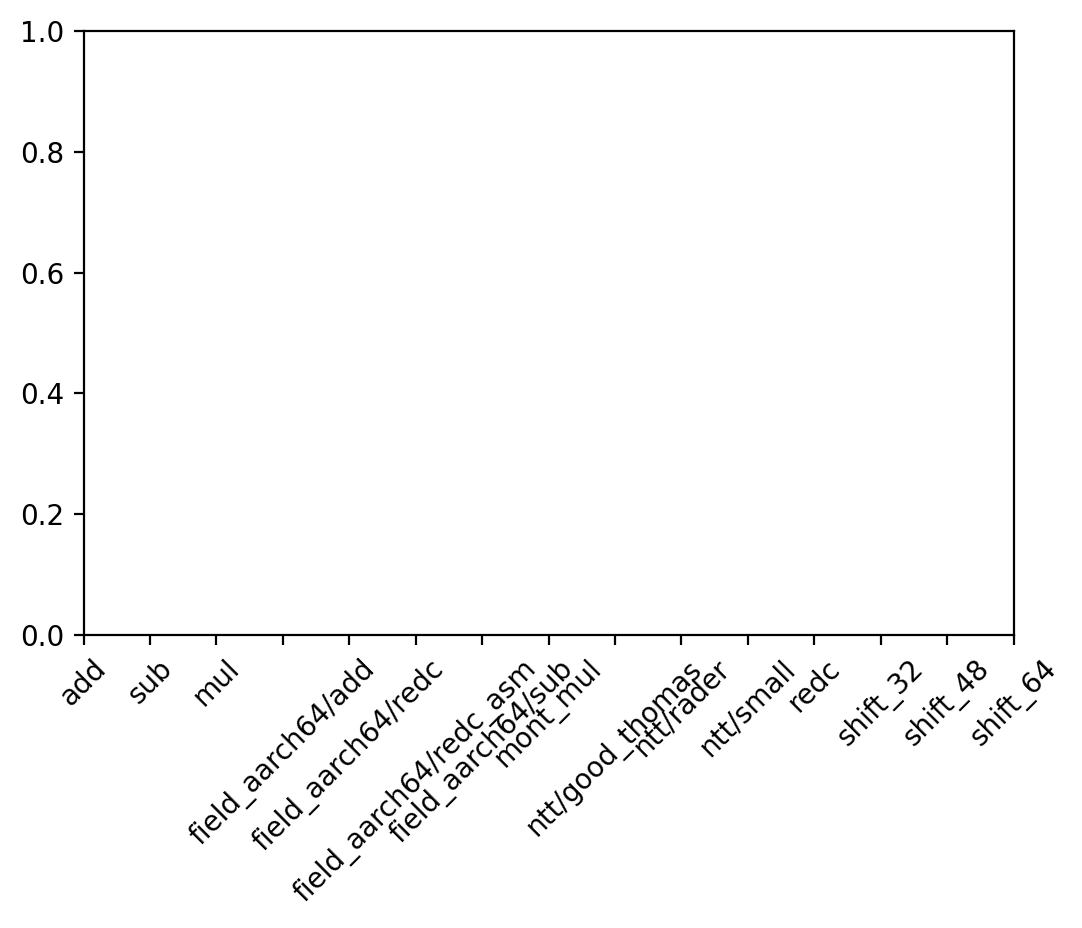

In [121]:
fig, ax = plt.subplots()

labels = df['name'].unique()
x = np.arange(len(labels))
ax.set_xticks(x, labels, rotation=45)

c = 0
for b in [1,2,4,8,16,32]:
    s = df[df['elms']==b]
    ax.bar(x + c * 0.15 - 0.375, s['new_ops'], width=0.1, color='green')
    ax.bar(x + c * 0.15 - 0.375, s['old_ops'], width=0.1, color='red')
    ax.bar(x + c * 0.15 - 0.375, s[['new_ops', 'old_ops']].min(axis=1), width=0.1, color='black')
    c += 1

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

ax.set_ylim((0, 7e9))
ax.yaxis.set_major_locator(MultipleLocator(1e9))
ax.yaxis.set_major_formatter(EngFormatter(unit='Ops'))
ax.yaxis.set_minor_locator(MultipleLocator(0.2e9))
ax.yaxis.grid(True, which='major', color='black', linewidth=0.6, linestyle='-')
ax.yaxis.grid(True, which='minor', color='black', linewidth=0.2, linestyle='-')

fig.savefig('reduce.png')

In [323]:
2**13

8192

In [324]:
536862720 / 2**13

65535.0

In [341]:
hex(9223372034707292160)

'0x7fffffff80000000'

In [342]:
hex(9223372039002259456)

'0x8000000080000000'

In [344]:
2**63 - 2**31

9223372034707292160

In [368]:
2**40 * 8 / 10**9

8796.093022208

In [372]:
3.5 * 11336/  3.2

12398.75

In [45]:
2**31 - 1

2147483647